# Bocconi - Interview_call n°67342

In [1]:
import os
os.environ['HF_HOME'] = 'D:/Downloads/GIT/RETSURVEY_PROT/huggingface/cache'
print(os.environ.get('HF_HOME'))

D:/Downloads/GIT/RETSURVEY_PROT/huggingface/cache


In [2]:
import random
from transformers import pipeline, set_seed, GPT2LMHeadModel, GPT2Tokenizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [28]:
# Instantiate the model and tokenizer with cache_dir argument
model = GPT2LMHeadModel.from_pretrained('gpt2', cache_dir='D:/Downloads/GIT/RETSURVEY_PROT/huggingface/cache')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', cache_dir='D:/Downloads/GIT/RETSURVEY_PROT/huggingface/cache')



## US Distribution Survey Generation

This code generates a synthetic survey dataset respecting the US distribution for political affiliation, income, age, and education. The goal of the survey is to understand people's thoughts on the retirement age and their reasons for retiring before the age of 65.

The code first defines the possible values for each feature, such as the reasons why people retire before the age of 65, age groups, education levels, income groups, and political affiliations, with their respective percentages.

Then, the code generates 15,000 examples by randomly selecting a reason ID from the defined list of reasons and generating a response to the question asked for the reason. The age group, gender, education level, income level, whether someone works in an intensive occupation, political affiliation, and support for postponing retirement are also randomly chosen according to their respective percentages.

The generated examples are stored in a list and saved as a CSV file every 50 iterations. This code can be useful for generating synthetic data for surveys and testing models or algorithms that analyze survey data.

In [ ]:
# Define possible values for each feature

# Define possible reasons why people retire before the age of 65 and the question to ask about them.
reasons = ["Laziness","Health problems","Financial concerns","Job Dissatisfaction","Family Responsibilities"]
question = "What do you think is the most common reason why people retire before the age of 65?"

# Define possible age groups and their respective percentages.
#['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 or older']
age_groups = [0, 1, 2, 3, 4, 5, 6, 7]
age_percents = [22.3, 9.4, 14.3, 15.4, 15.4, 12.7, 7.4, 3.1]

# Define possible education levels and their respective percentages.
# ['Less than a high school diploma', 'High school diploma or equivalent', 'Some college or associate's degree', 'Bachelor's degree or higher']
edu_groups = [0, 1, 2, 3]
edu_percents = [12.5, 27.6, 29.3, 30.6]

# Define possible income groups and their respective percentiles.
# ['$1 to $9,999', '$10,000 to $24,999', '$25,000 to $49,999', '$50,000 to $74,999', '$75,000 to $99,999', '$100,000 to $149,999', '$150,000 to $199,999', '$200,000 or more']
income_groups = [0, 1, 2, 3, 4, 5, 6, 7]
income_percentiles = [10.8, 17.5, 22.7, 18.9, 12.2, 11.5, 4.0, 2.4]

# Define possible political affiliations and their respective percentages.
#['Democrat', 'Republican', 'Independent']
pol_groups = [0, 1, 2]
pol_percents = [33, 29, 38]

# Generate 15,000 examples
examples = []
for i in range(15000):
    example = {}
    example["ID"] = i
    example['Reason_id'] = random.randint(0, 4) # Choose a random reason ID
    example["Reason"] = reasons[example['Reason_id'] ] # Use the corresponding reason for the ID
    set_seed(i)
    # Generate a response to the question asked for the reason.
    prompt = question + ' ' + example["Reason"] + '.'
    Text = tokenizer.decode(model.generate(
                                                tokenizer.encode(prompt, return_tensors='pt'), do_sample=True,
                                                max_length=50, num_beams=2, no_repeat_ngram_size=2, early_stopping=True,
                                                num_return_sequences=1)[0],skip_special_tokens=True)
    example["Text"] = Text[len(prompt):].replace('\n','') # Get just the answer
    example["Age"] = random.choices(age_groups, weights=age_percents)[0] # Choose a age group respecting percentiles
    example["Gender"] = random.randint(0, 1) # Choose a random gender
    example["Education"] = random.choices(edu_groups, weights=edu_percents)[0] # Choose a education level respecting percentiles
    example["Income"] = random.choices(income_groups, weights=income_percentiles)[0] # Choose a income level respecting percentiles
    example["Physically_occupation"] = random.randint(0, 1) # Choose a random binary to represent if someone work in a intensive occupation
    example["Political_affiliation"] = random.choices(pol_groups, weights=pol_percents)[0] # Choose political affiliation respecting percentiles
    example["Support"] = random.randint(0, 1) # Choose randomly if someone supports postponing retirement
    examples.append(example)
    if i % 50 == 0:
        example_df = pd.DataFrame(examples)
        example_df.to_csv('survey.csv',index=False)

Import the csv file in case we do not want to wait 9 hours to run the cell above. Also, creating a hot encoding for the column Reason

In [3]:
example_df = pd.read_csv('survey.csv')

# create one-hot encoding for Reason column
reason_dummies = pd.get_dummies(example_df['Reason'])
example_df = pd.concat([example_df, reason_dummies], axis=1)

### Logistic Regression

In [4]:
import statsmodels.api as sm

# define the independent variables
X = example_df[['Age', 'Gender', 'Education', 'Income', 'Physically_occupation',
                'Political_affiliation', 'Laziness' , 'Health problems',
                'Financial concerns', 'Job Dissatisfaction', 'Family Responsibilities']]

# add intercept term
X = sm.add_constant(X)

# define the dependent variable
y = example_df['Support']

# fit the logistic regression model
model = sm.Logit(y, X).fit()

# print summary table of regression results
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.692530
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:                Support   No. Observations:                14951
Model:                          Logit   Df Residuals:                    14939
Method:                           MLE   Df Model:                           11
Date:                Tue, 09 May 2023   Pseudo R-squ.:               0.0007601
Time:                        14:11:42   Log-Likelihood:                -10354.
converged:                       True   LL-Null:                       -10362.
Covariance Type:            nonrobust   LLR p-value:                    0.1506
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.0142   1.79e+06    7.9e-09      1.000   -3.51e+06   

### Come up with a stochastic formula for supporting

The code applies a stochastic formula using a softmax function to determine whether someone supports postponing retirement based on their age, gender, education, income, physically occupation, political affiliation, and the reason they retire early.

Here\'s how the formula works:

$\text{logit}(Y)=\beta_{0}+\beta_{1}Age+\beta_{2}Gender+\beta_{3}Education+\beta_{4}Income+\beta_{5}Physically_Occupation+\beta_{6}Political_Affiliation+\beta_{7}Laziness+\beta_{8}Health_problems+\beta_{9}Financial_concerns+\beta_{10}Job_Dissatisfaction+\beta_{11}Family_Responsibilities+\epsilon$

where $\text{logit}(Y)$ is the log odds of the dependent variable $Y$, $\beta_0$ is the intercept, and $\beta_1$ through $\beta_{11}$ are the coefficients for each of the independent variables Age, Gender, Education, Income, Physically Occupation, Political Affiliation, Laziness, Health problems, Financial concerns, Job Dissatisfaction, and Family Responsibilities, respectively. The error term is denoted by $\epsilon$.

In [7]:
# Define coefficients for each feature's effect on support
age_coeff = 0.05
gender_coeff = 0.1
edu_coeff = 0.05
income_coeff = 0.05
occupation_coeff = 0.2
pol_coeff = 0.2
reason_coeff_laziness = 0.3
reason_coeff_health = -0.5
reason_coeff_financial = 0.5
reason_coeff_job = 0
reason_coeff_family = 0.3 

# Define intercept and noise
intercept = -0.6
noise = np.random.normal(0,0.2,size=len(example_df))


# Generate dependent variable Y in a logit way
logit = (age_coeff * example_df['Age'].values +
         gender_coeff * example_df['Gender'].values +
         edu_coeff * example_df['Education'].values +
         income_coeff * example_df['Income'].values +
         occupation_coeff * example_df['Physically_occupation'].values +
         pol_coeff * example_df['Political_affiliation'].values +
         reason_coeff_laziness * example_df['Laziness'].values +
         reason_coeff_health * example_df['Health problems'].values +
         reason_coeff_financial * example_df['Financial concerns'].values +
         reason_coeff_job * example_df['Job Dissatisfaction'].values +
         reason_coeff_family * example_df['Family Responsibilities'].values +
         intercept + noise
            )

example_df['logit'] = logit
example_df['Support_2'] = np.random.binomial(n=1, p=np.exp(logit)/(1+np.exp(logit)))

In [9]:
import statsmodels.api as sm

# define the independent variables
X = example_df[['Age', 'Gender', 'Education', 'Income', 'Physically_occupation',
                'Political_affiliation', 'Laziness' , 'Health problems',
                'Financial concerns', 'Job Dissatisfaction', 'Family Responsibilities']]

# add intercept term
X = sm.add_constant(X, prepend = False)

# define the dependent variable
y = example_df['Support_2'].values

# fit the logistic regression model
model = sm.Logit(y, X).fit()

# print summary table of regression results
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.665965
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                14951
Model:                          Logit   Df Residuals:                    14940
Method:                           MLE   Df Model:                           10
Date:                Tue, 09 May 2023   Pseudo R-squ.:                 0.02926
Time:                        14:12:08   Log-Likelihood:                -9956.8
converged:                       True   LL-Null:                       -10257.
Covariance Type:            nonrobust   LLR p-value:                1.637e-122
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Age                         0.0533      0.008      6.546      0.000       0.037   

### Sentiment Analyses

In [10]:
import pandas as pd
from transformers import pipeline
from tqdm import tqdm

# Initialize the sentiment analysis pipeline
sentiment_classifier = pipeline('sentiment-analysis')

# Apply sentiment analysis to each row in the dataset
sentiments = []
for text in tqdm(example_df['Text']):
    try:
        sentiment = sentiment_classifier(text)[0]
        sentiments.append(sentiment['label'])
    except:
        sentiments.append('No_text')

# Add the 'Sentiment' column to the dataset
example_df['Sentiment'] = sentiments

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
100%|██████████| 14951/14951 [13:29<00:00, 18.48it/s]


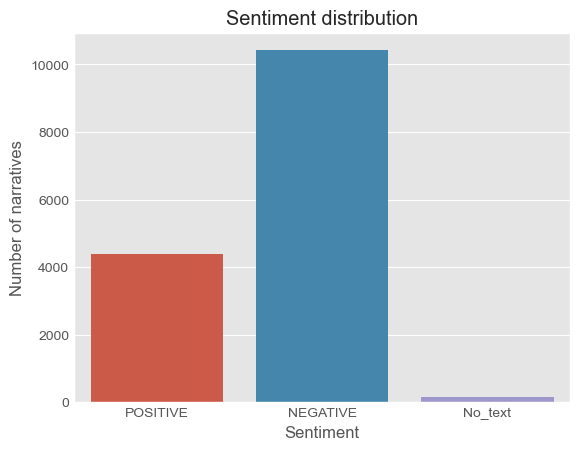

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Create a bar plot of the number of narratives for each sentiment
sns.countplot(x='Sentiment', data=example_df)
plt.title('Sentiment distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of narratives')
plt.show()

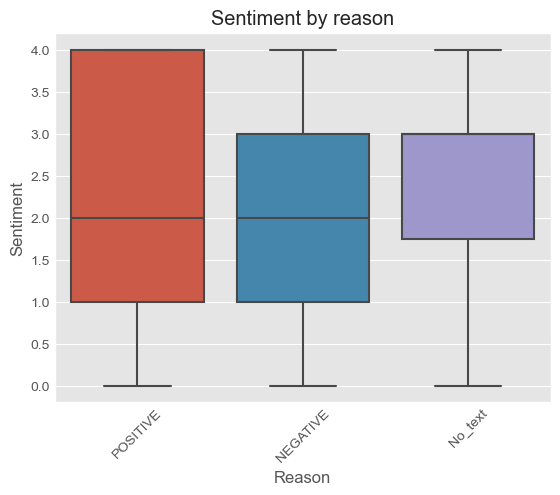

In [28]:
# Create a box plot of the sentiment by reason
sns.boxplot(x='Sentiment', y='Reason_id', data=example_df)
plt.title('Sentiment by reason')
plt.xlabel('Reason')
plt.ylabel('Sentiment')
plt.xticks(rotation=45)
plt.show()

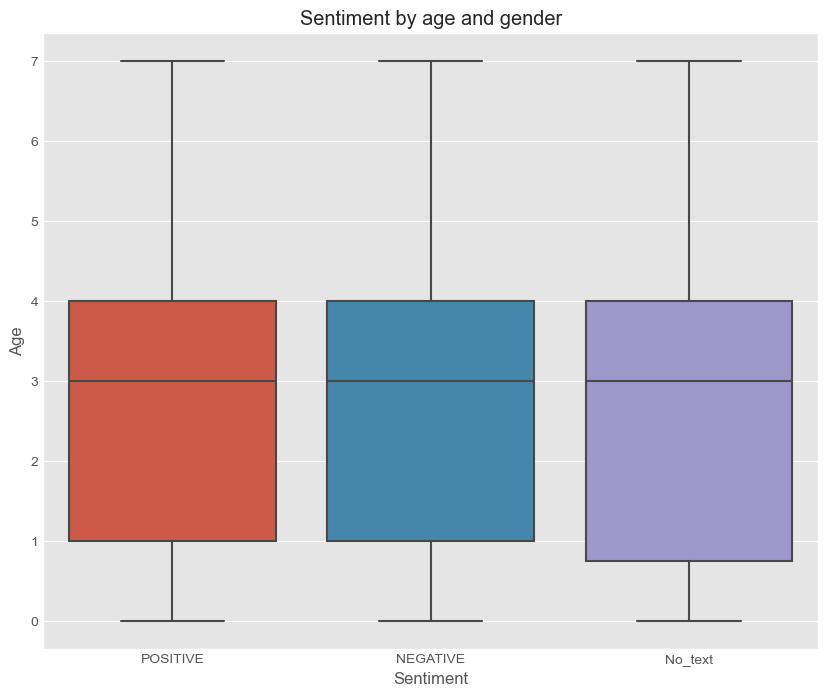

In [30]:
# Create a box plot of the sentiment by age
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.boxplot(x='Sentiment', y='Age', data=example_df)
ax.set_title('Sentiment by age and gender')
ax.set_xlabel('Sentiment')
ax.set_ylabel('Age')
plt.show()

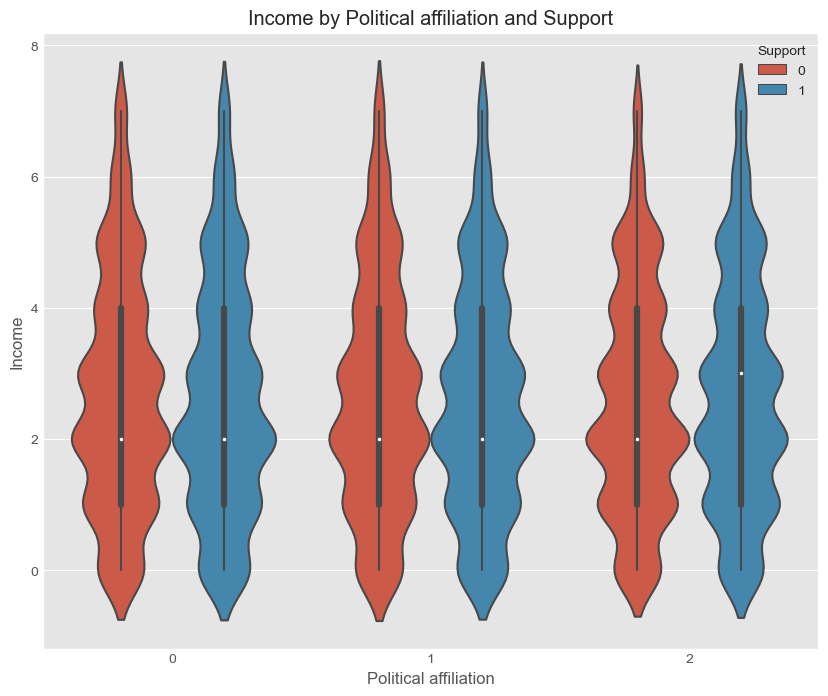

In [41]:
# Create a box plot of the sentiment by age
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.violinplot(data=example_df, x="Political_affiliation", y="Income", hue="Support")
ax.set_title('Income by Political affiliation and Support')
ax.set_xlabel('Political affiliation')
ax.set_ylabel('Income')
plt.show()

## Text Investigation

To investigate the most important words for each type of reason in our dataset, we can use a text analysis approach. One common method is to use a bag-of-words model, which represents each document as a vector of word counts. Then, you can use dimensionality reduction techniques such PCA to visualize the high-dimensional vectors in 2D space

In [73]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA

# Define the corpus as the text column
corpus = example_df['Text'].fillna('no_text')

# Define the vectorizer to convert text to bag-of-words vectors
vectorizer = CountVectorizer(stop_words='english',strip_accents='unicode')

# Create the bag-of-words matrix
bow_matrix = vectorizer.fit_transform(corpus)

# Define the labels as the reason column
labels = example_df['Reason']

# Define the colors for each reason
colors = ['blue', 'green', 'red', 'purple', 'orange']


# Get the top 10 words for each reason
reasons = ["Laziness","Health problems","Financial concerns","Job Dissatisfaction","Family Responsibilities"]
# loop through each reason and get the most common words
for reason in reasons:
    # get the examples for the current reason
    reason_examples = example_df[example_df[reason]==1]
    
    # get the text for the reason examples
    reason_text = reason_examples['Text'].fillna('no_text').values
    
    # count the word frequencies
    word_counts = vectorizer.fit_transform(reason_text)
    
    # get the feature names
    feature_names = vectorizer.get_feature_names_out()
    
    # get the word counts as an array
    counts = np.asarray(word_counts.sum(axis=0))[0]
    
    # get the indices that sort the counts array in descending order
    sorted_indices = np.argsort(counts)[::-1]
    
    # get the top 10 most important words
    top_words = [feature_names[i] for i in sorted_indices[:10]]
    
    # print the top words for the reason
    print(reason + ': ' + str(top_words))


Laziness: ['people', 'laziness', 'retire', 'think', 'don', 'early', 'retirement', 'lot', '65', 'problem']
Health problems: ['people', 'think', 'health', 'retire', 'don', 'problems', 'retirement', 'lot', '65', 'early']
Financial concerns: ['think', 'retirement', 'people', 'retire', 'lot', 'don', 'financial', 'early', 'reasons', 'age']
Job Dissatisfaction: ['people', 'job', 'think', 'retire', 'don', 'reasons', 'early', 'question', 'want', 'retirement']
Family Responsibilities: ['family', 'retirement', 'retire', 'responsibilities', 'people', 'early', 'reasons', '65', 'age', 'children']


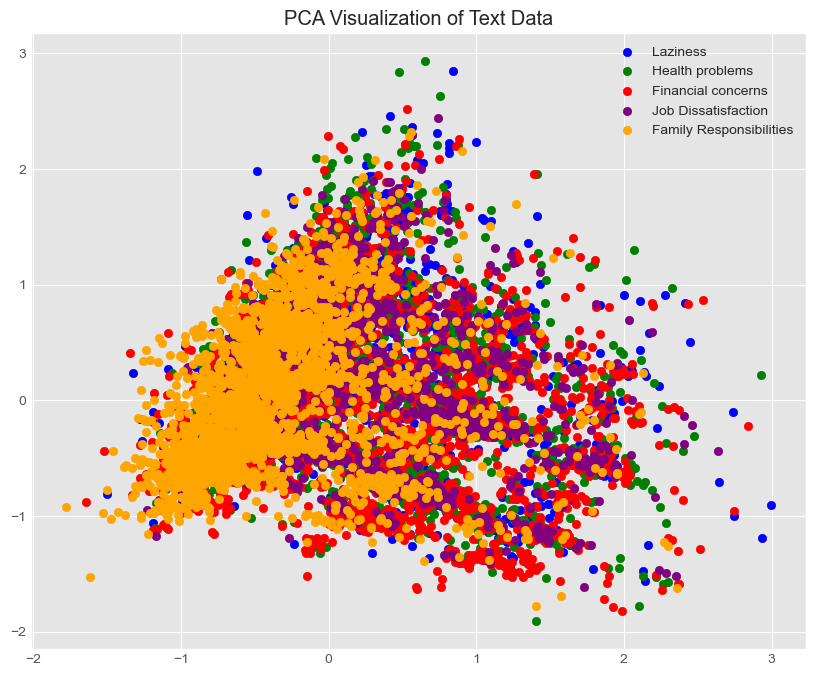

In [74]:
# Define the PCA and TSE models
pca = PCA(n_components=2)

# Fit and transform the bag-of-words matrix with the PCA model
pca_matrix = pca.fit_transform(bow_matrix.toarray())

# Plot the PCA results
plt.figure(figsize=(10, 8))
for i, reason in enumerate(reasons):
    plt.scatter(pca_matrix[labels == reason, 0], pca_matrix[labels == reason, 1], c=colors[i], label=reason)
plt.legend()
plt.title('PCA Visualization of Text Data')
plt.show()